In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/model_dir.zip

/content/drive/MyDrive/model_dir.zip


In [ ]:
!ls /content/drive/MyDrive/my_config.zip

/content/drive/MyDrive/my_config.zip


In [ ]:
!unzip /content/drive/MyDrive/model_dir.zip

Archive:  /content/drive/MyDrive/model_dir.zip
  inflating: model_dir/checkpoint    
  inflating: model_dir/configuration  


In [ ]:
!unzip /content/drive/MyDrive/my_config.zip

Archive:  /content/drive/MyDrive/my_config.zip
   creating: kaggle/working/test3/model_dir/
   creating: kaggle/working/test3/model_dir/test/
  inflating: kaggle/working/test3/model_dir/test/checkpoint  
  inflating: kaggle/working/test3/model_dir/test/configuration  


In [ ]:
!pip install muspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 26.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
  Created wheel for pretty-midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592289 sha256=8b16ebc716895202438efaf17fcdf460de1543a2c914f021958e1da8e35e7ef3
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty-midi
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [ ]:
import os

from matplotlib import pyplot as plt
import matplotlib as mpl
import muspy
import torch

import constants


def plot_pianoroll(muspy_song, save_dir=None, name='pianoroll'):

    lines_linewidth = 4
    axes_linewidth = 4
    font_size = 34
    fformat = 'png'
    xticklabel = False
    label = 'y'
    figsize = (20, 10)
    dpi = 200

    with mpl.rc_context({'lines.linewidth': lines_linewidth,
                         'axes.linewidth': axes_linewidth,
                         'font.size': font_size}):

        fig, axs_ = plt.subplots(constants.N_TRACKS, sharex=True,
                                 figsize=figsize)
        fig.subplots_adjust(hspace=0)
        axs = axs_.tolist()
        muspy.show_pianoroll(music=muspy_song, yticklabel='off', xtick='off',
                             label=label, xticklabel=xticklabel,
                             grid_axis='off', axs=axs, preset='full')

        if save_dir:
            plt.savefig(os.path.join(save_dir, name + "." + fformat),
                        format=fformat, dpi=dpi)


def plot_structure(s_tensor, save_dir=None, name='structure'):

    lines_linewidth = 1
    axes_linewidth = 1
    font_size = 14
    fformat = 'svg'
    dpi = 200

    n_bars = s_tensor.shape[0]
    figsize = (3 * n_bars, 3)

    n_timesteps = s_tensor.size(2)
    resolution = n_timesteps // 4
    s_tensor = s_tensor.permute(1, 0, 2)
    s_tensor = s_tensor.reshape(s_tensor.shape[0], -1)

    with mpl.rc_context({'lines.linewidth': lines_linewidth,
                         'axes.linewidth': axes_linewidth,
                         'font.size': font_size}):

        plt.figure(figsize=figsize)
        plt.pcolormesh(s_tensor, edgecolors='k', linewidth=1)
        ax = plt.gca()

        plt.xticks(range(0, s_tensor.shape[1], resolution),
                   range(1, 4*n_bars + 1))
        plt.yticks(range(0, s_tensor.shape[0]), constants.TRACKS)

        ax.invert_yaxis()

        if save_dir:
            plt.savefig(os.path.join(save_dir, name + "." + fformat),
                        format=fformat, dpi=dpi)


def plot_stats(stat_names, stats_tr, stats_val=None, eval_every=None,
               labels=None, rx=None, ry=None):

    for i, stat in enumerate(stat_names):

        label = stat if not labels else labels[i]

        plt.plot(range(1, len(stats_tr[stat])+1), stats_tr[stat],
                label=label+' (TR)')

        if stats_val:
            plt.plot(range(eval_every, len(stats_tr[stat])+1, eval_every),
                    stats_val[stat], '.', label=label+' (VL)')

    plt.grid()

    plt.ylim(ry) if ry else plt.ylim(0)
    plt.xlim(rx) if rx else plt.xlim(0)

    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Losses')
    plt.legend()
    plt.show()


# Dictionary that maps loss statistic name to plot label
loss_labels = {
    'tot': 'Total Loss',
    'structure': 'Structure',
    'pitch': 'Pitches',
    'dur': 'Duration',
    'reconstruction': 'Reconstruction Term',
    'kld': 'KLD',
    'beta*kld': 'beta * KLD'
}


def plot_losses(model_dir, losses, plot_val=False):

    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [loss_labels[loss] for loss in losses]

    tr_losses = checkpoint['tr_losses']
    val_losses = checkpoint['val_losses'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(losses, tr_losses, stats_val=val_losses,
               eval_every=eval_every, labels=labels, rx=(0))


# Dictionary that maps accuracy statistic name to plot label
accuracy_labels = {
    's_acc': 'Struct. Accuracy',
    's_precision': 'Struct. Precision',
    's_recall': 'Struct. Recall',
    's_f1': 'Struct. F1',
    'pitch': 'Pitch Accuracy',
    'pitch_drums': 'Pitch Accuracy (Drums)',
    'pitch_non_drums': 'Pitch Accuracy (Non Drums)',
    'dur': 'Duration Accuracy',
    'note': 'Note Accuracy'
}


def plot_accuracies(model_dir, accuracies, plot_val=False):

    checkpoint_path = os.path.join(model_dir, 'checkpoint')
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    labels = [accuracy_labels[accuracy] for accuracy in accuracies]

    tr_accuracies = checkpoint['tr_accuracies']
    val_accuracies = checkpoint['val_accuracies'] if plot_val == True else None
    eval_every = checkpoint['eval_every'] if plot_val == True else None

    plot_stats(accuracies, tr_accuracies, stats_val=val_accuracies,
               eval_every=eval_every, labels=labels, ry=(0, 1))

Функция потерь и график точности для лучшей модели с 2-тактовыми последовательностями

In [ ]:
model_dir = 'model_dir'

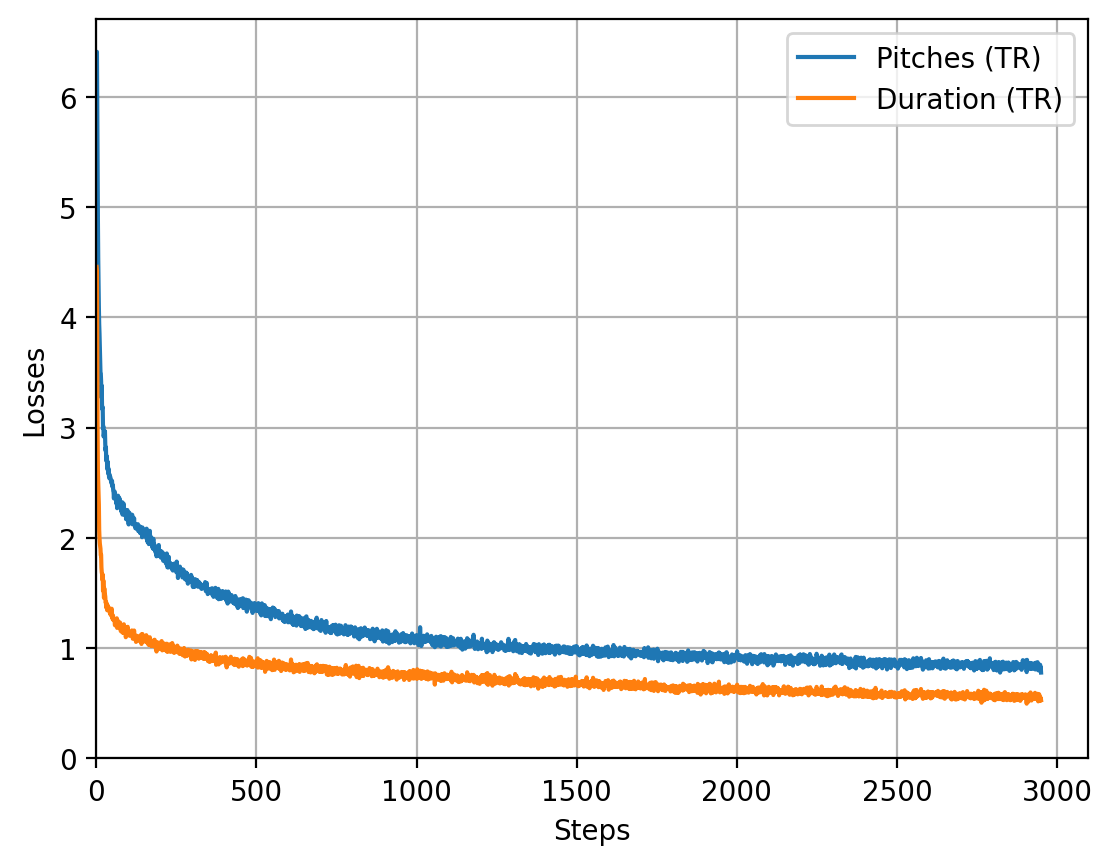

In [ ]:
# Uncomment the losses that have to be plotted
losses = [
    #'tot',
    #'structure',
    'pitch',
    'dur',
    #'reconstruction',
    #'kld',
    #'beta*kld'
]
plot_losses(model_dir, losses, plot_val=True)

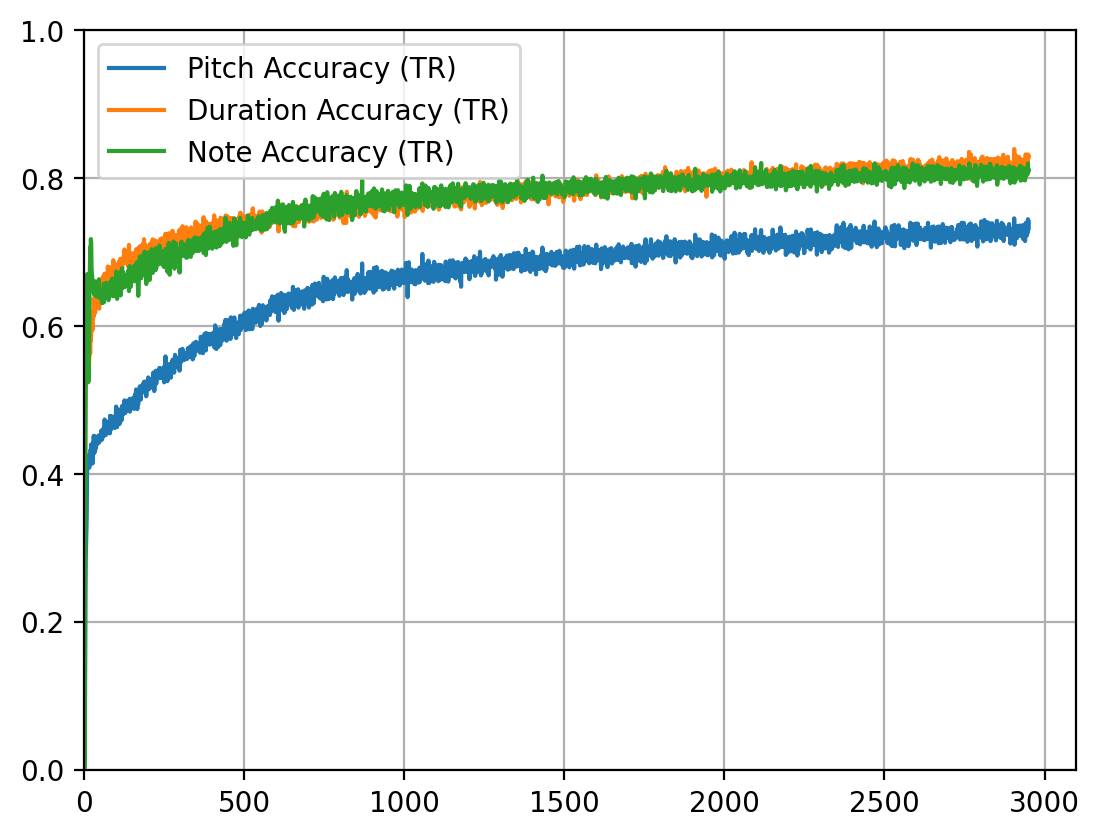

In [ ]:
# Uncomment the accuracies that have to be plotted
accuracies = [
    #'s_acc',
    #'s_precision',
    #'s_recall',
    #'s_f1',
    'pitch',
    #'pitch_drums',
    #'pitch_non_drums',
    'dur',
    'note'
]
plot_accuracies(model_dir, accuracies, plot_val=True)

In [ ]:
Функция потерь и график точности для лучшей модели с 16-тактовыми последовательностями

In [ ]:
model_dir = '16_bars'

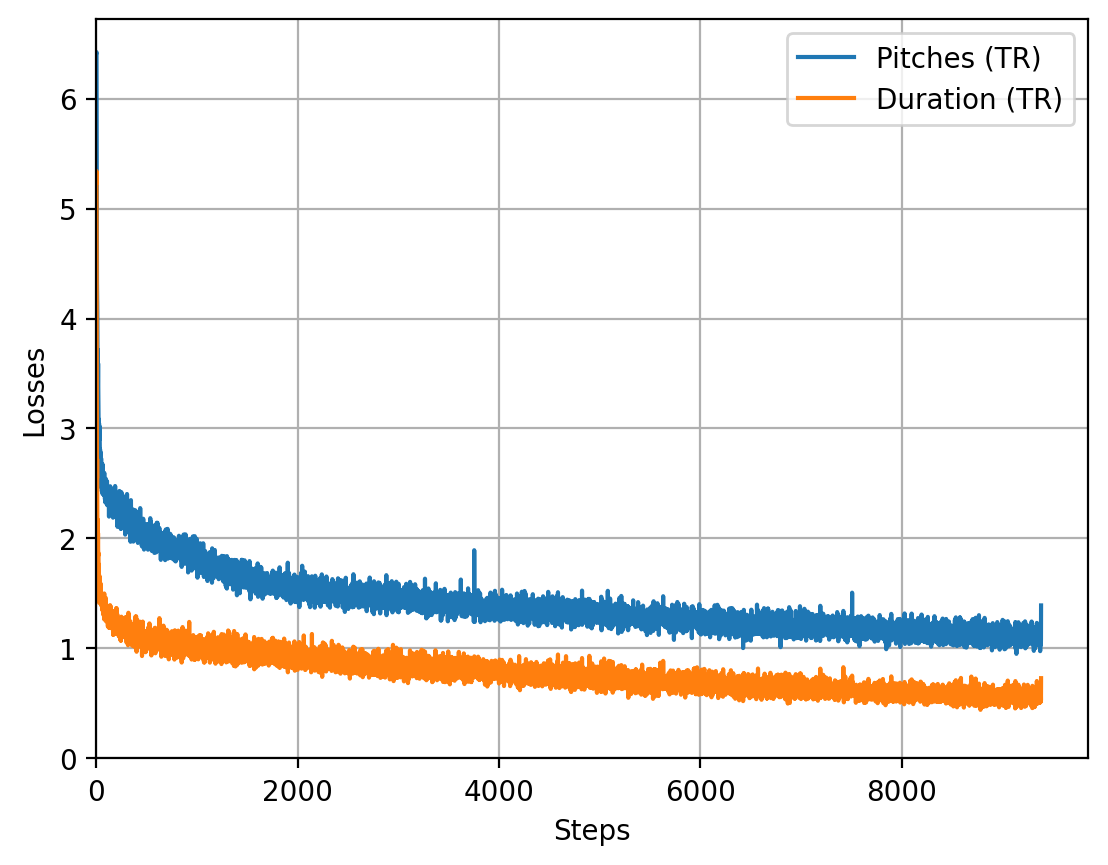

In [ ]:
# Uncomment the losses that have to be plotted
losses = [
    #'tot',
    #'structure',
    'pitch',
    'dur',
    #'reconstruction',
    #'kld',
    #'beta*kld'
]
plot_losses(model_dir, losses, plot_val=True)

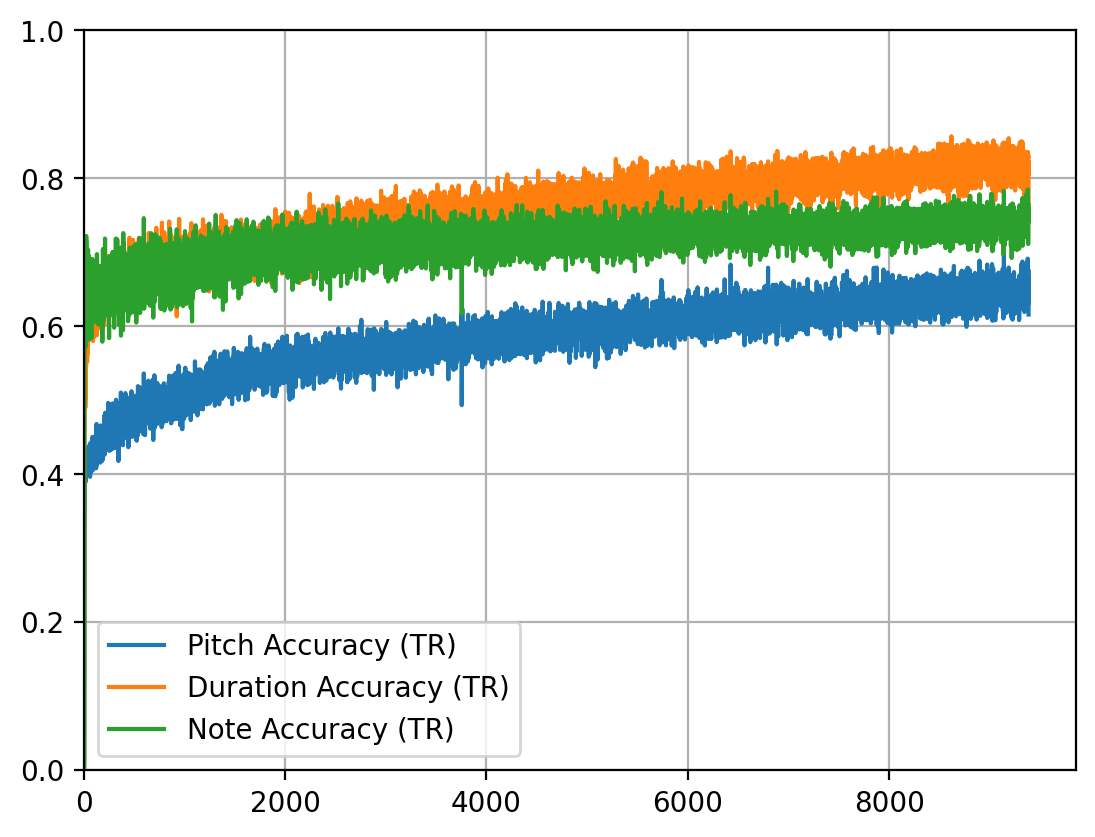

In [ ]:
# Uncomment the accuracies that have to be plotted
accuracies = [
    #'s_acc',
    #'s_precision',
    #'s_recall',
    #'s_f1',
    'pitch',
    #'pitch_drums',
    #'pitch_non_drums',
    'dur',
    'note'
]
plot_accuracies(model_dir, accuracies, plot_val=True)